In [1]:
# # TODO: A more generic way is needed here to load the path
# import sys

# sys.path.append(
#     "/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src"
#     # "/global/homes/p/peishi89/jax-watershed/src"
# )

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import jax.numpy as jnp

from jax_canoak.subjects.utils import es as fes

# from jax_canoak.shared_utilities.forcings.get_forcing import get_modis_lai
# from jax_canoak.shared_utilities.forcings.get_forcing import get_modis_et

%load_ext autoreload
%autoreload 2

In [3]:
dir_flux_data = Path("../data/fluxtower/US-Hn1")
dir_modis_data = Path("../data/modis/US-Hn1")
f_forcing = dir_flux_data / "US-Hn1.csv"
f_chamber = dir_flux_data / "Hn1_chamber.csv"
# f_modis_lai = dir_modis_data / "LAI" / "filtered_scaled_Lai_500m.csv"
# modis_lai_scale_factor = 0.1
f_modis_lai = dir_modis_data / "MCD15A3H" / "filtered_scaled_Lai_500m.csv"
f_modis_le = dir_modis_data / "MOD16A2GF" / "filtered_scaled_LE_500m.csv"

modis_lai_scale_factor = 0.1
modis_le_scale_factor = 1e4
pixel_ind = 144

# Flux tower data

In [4]:
# Read the dataframe
df = pd.read_csv(f_forcing)

In [5]:
# Vegetation height
# Sagebrush: ~1.2m https://workbasedlearning.pnnl.gov/pals/resource/cards/sagebrush.stm
df["veg_ht"] = 1.2

In [6]:
# Get the time frame
df.index = pd.to_datetime(df["TIMESTAMP_END"], format="%Y-%m-%d %H:%M:%S")

<Axes: xlabel='TIMESTAMP_END'>

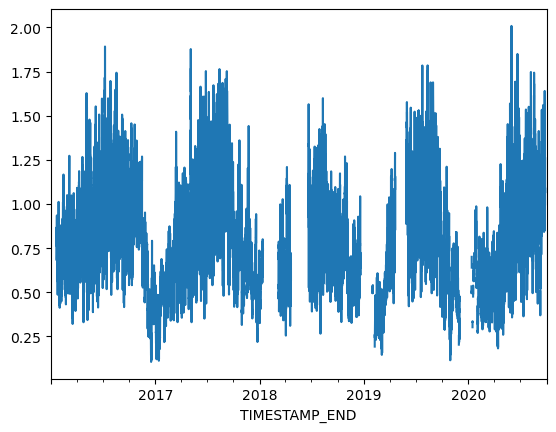

In [7]:
# Calculate vapor pressure from air temperature and relative humidity
es = fes(df["Tair"].values + 273.15)
# ea = es - df['VPD'].values*1000
df["rH"] = np.clip(df["rH"], a_max=100, a_min=0)
ea = es * df["rH"].values / 100

df["eair"] = ea / 1e3  # kPa
df["eair"].plot()

# MODIS data


<Axes: xlabel='2'>

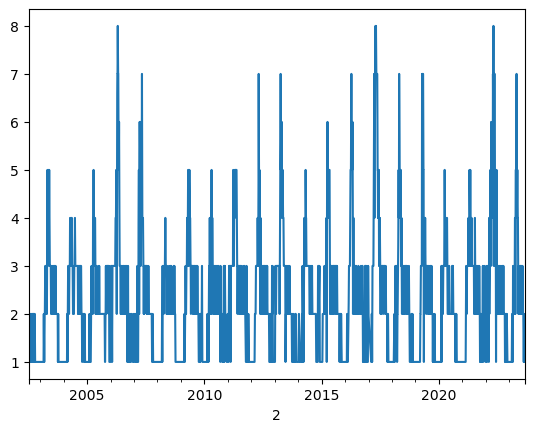

In [8]:
df_modis_lai = pd.read_csv(f_modis_lai, header=None)
df_modis_lai.index = df_modis_lai[2].apply(
    lambda x: pd.to_datetime(x[1:], format="%Y%j")
)
df_modis_lai["LAI"] = df_modis_lai[4 + pixel_ind].apply(
    lambda x: float(x) / modis_lai_scale_factor if x != "F" else np.nan
)
df_modis_lai = df_modis_lai[["LAI"]]
df_modis_lai = df_modis_lai.resample("30min").interpolate()
df_modis_lai["LAI"].plot()

<Axes: xlabel='2'>

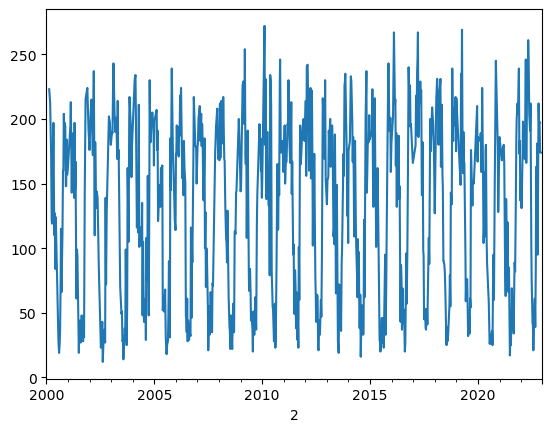

In [9]:
df_modis_le = pd.read_csv(f_modis_le, header=None)
df_modis_le.index = df_modis_le[2].apply(lambda x: pd.to_datetime(x[1:], format="%Y%j"))
df_modis_le["LE_MODIS"] = df_modis_le[4 + pixel_ind].apply(
    lambda x: float(x) / modis_le_scale_factor if x != "F" else np.nan
)
df_modis_le = df_modis_le[["LE_MODIS"]]
df_modis_le = df_modis_le.resample("30min").interpolate()
df_modis_le["LE_MODIS"].plot()

In [10]:
df_modis = pd.concat([df_modis_lai, df_modis_le])
df_modis.head()

,LAI,LE_MODIS
2,,
2002-07-04 00:00:00,2.000000,NaN
2002-07-04 00:30:00,1.994792,NaN
2002-07-04 01:00:00,1.989583,NaN
2002-07-04 01:30:00,1.984375,NaN
2002-07-04 02:00:00,1.979167,NaN


In [11]:
df_modis = df_modis_lai.join(df_modis_le)

In [12]:
# data_json['subset'][5]['data']
# Get MODIS LAI
# start, end = df.index[0], df.index[-1]
# df_modis = get_modis_lai("US-Hn1", start, end, method='mean', sample_freq="30min")
# df_modis, data_json = get_modis_lai(
#   "US-Hn1", start, end, method='mean', sample_freq="30min"
# )
# df_modis["LAI"].plot()

In [13]:
# df_modis = pd.read_csv(f_modis_lai, header=None)
# df_modis.index = df_modis[2].apply(lambda x: pd.to_datetime(x[1:], format="%Y%j"))
# df_modis["LAI"] = df_modis[6].apply(
#     lambda x: float(x) / modis_lai_scale_factor if x != "F" else np.nan
# )
# df_modis = df_modis[["LAI"]]
# df_modis = df_modis.resample("30min").interpolate()
# df_modis["LAI"].plot()

# Soil respiration data

In [14]:
# Get soil respiration
df_chamber = pd.read_csv(f_chamber)
df_chamber["Timestamp"] = pd.to_datetime(
    df_chamber["Timestamp"], format="%Y-%m-%d %H:%M:%S"
)
df_chamber.set_index("Timestamp", inplace=True)
df_chamber = df_chamber.resample("30T").mean()

# Combine data

In [15]:
df = df.join(df_modis)
df = df.join(df_chamber[["Rsoil"]])

# Spectral analysis

In [16]:
start, end = "2016-06-01", "2017-06-30"
LE = df["LE"].interpolate()[start:end]
H = df["H"].interpolate()[start:end]

# freq   = jnp.fft.fftfreq(H.size, d=0.5)
freq = jnp.arange(LE.size) / (1 / (60 * 30))
fft_le = jnp.fft.fft(LE.values)
fft_h = jnp.fft.fft(H.values)

freq = freq[: int(LE.size / 2)]
fft_le = fft_le[: int(LE.size / 2)]
fft_h = fft_h[: int(LE.size / 2)]
# fft_le = jnp.fft.fftshift(jnp.fft.fft(LE.values))
# fft_h  = jnp.fft.fftshift(jnp.fft.fft(H.values))

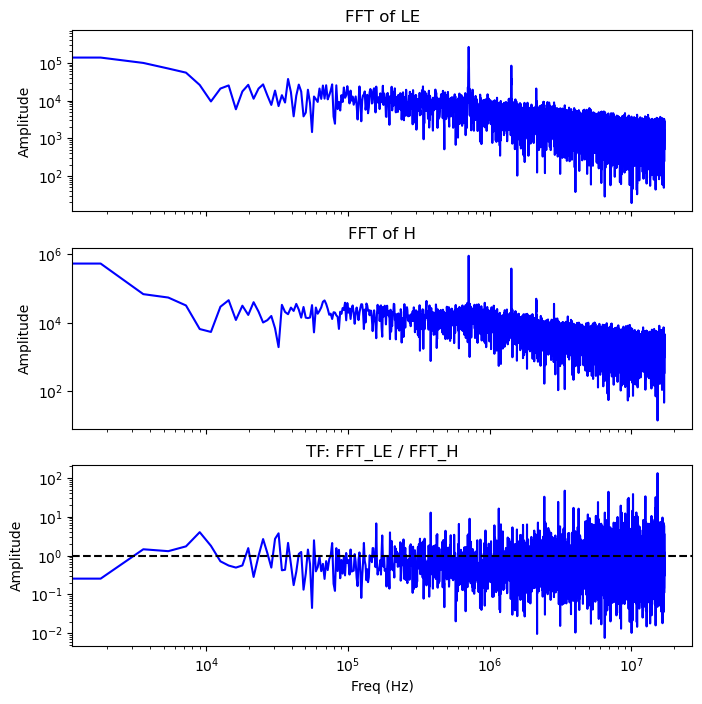

In [17]:
fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)
ax = axes[0]
ax.plot(freq, jnp.abs(fft_le), "b")
ax.set(yscale="log", xscale="log", title="FFT of LE", ylabel="Amplitude")
ax = axes[1]
ax.plot(freq, jnp.abs(fft_h), "b")
ax.set(yscale="log", xscale="log", title="FFT of H", ylabel="Amplitude")
ax = axes[2]
ax.plot(freq, jnp.abs(fft_le) / jnp.abs(fft_h), "b")
ax.axhline(y=1.0, color="k", linestyle="--")
ax.set(
    yscale="log",
    xscale="log",
    title="TF: FFT_LE / FFT_H",
    ylabel="Amplitude",
    xlabel="Freq (Hz)",
);

# Forcings

In [16]:
# The following information is needed to drive CANOAK
in_varns = [
    "Year",
    "DoY",
    "Hour",
    "Tair",
    "Rg",
    "eair",
    "WS_x",
    "CO2",
    "PA",
    "Ustar",
    "TS_15cm",
    "SWC_15cm",
    "veg_ht",
    "LAI",
]

<Axes: xlabel='TIMESTAMP_END'>

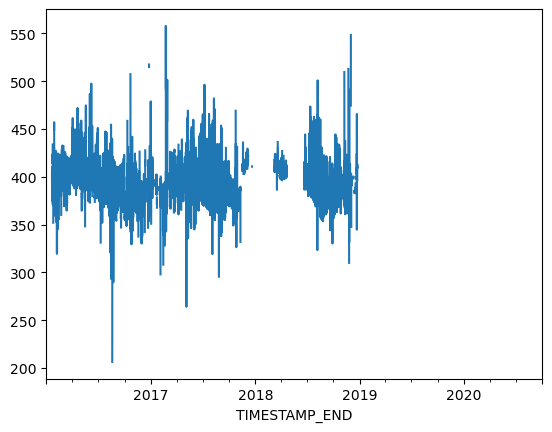

In [17]:
# Clean up the negative CO2 ppm
df.loc[df["CO2"] <= 100, "CO2"] = np.nan
df["CO2"].plot()

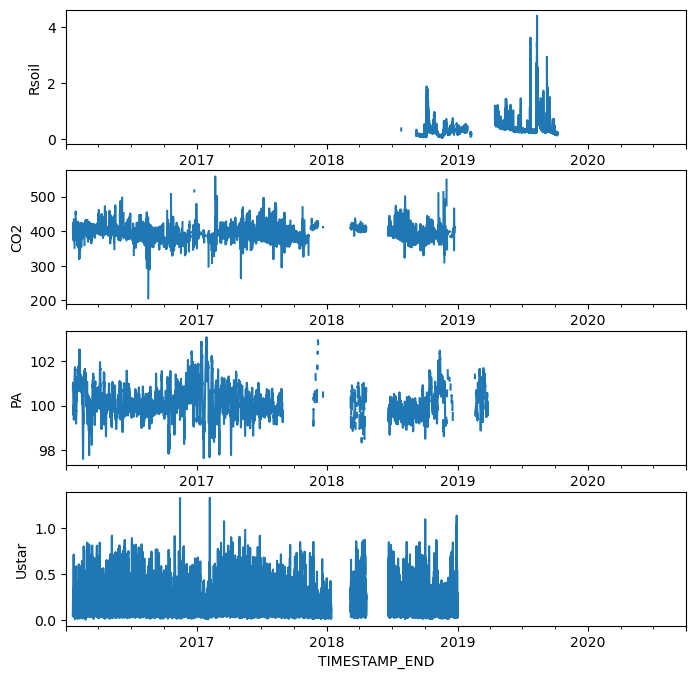

In [18]:
varns = ["Rsoil", "CO2", "PA", "Ustar"]
fig, axes = plt.subplots(len(varns), 1, figsize=(8, 8))
for i, varn in enumerate(varns):
    ax = axes[i]
    df[varn].plot(ax=ax)
    ax.set(ylabel=varn)

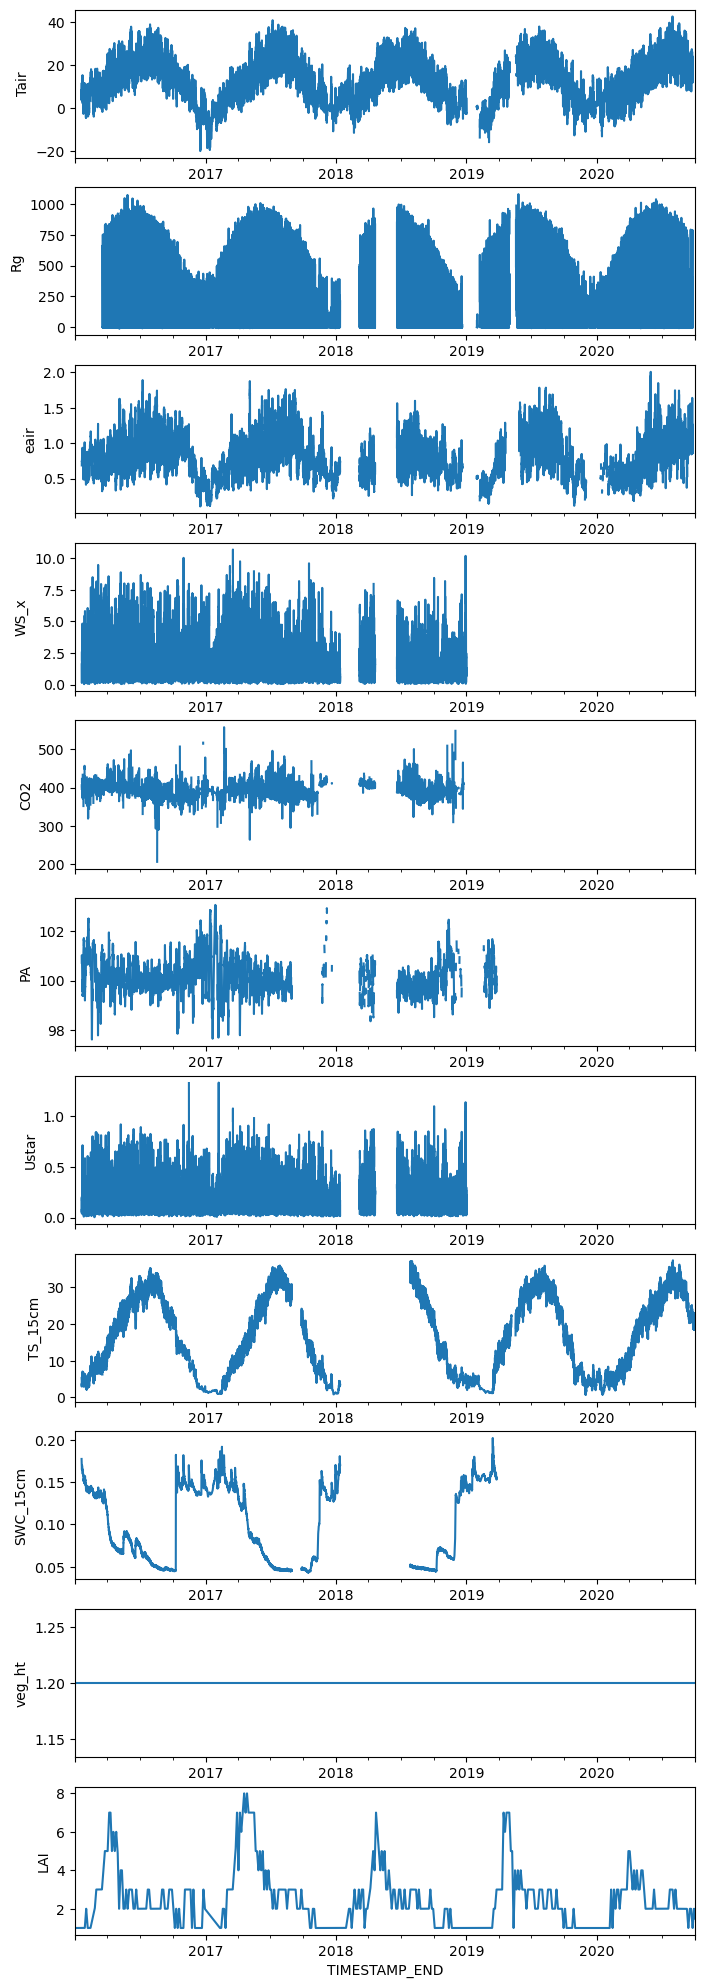

In [19]:
varns = in_varns[3:]
fig, axes = plt.subplots(len(varns), 1, figsize=(8, 25))
for i, varn in enumerate(varns):
    ax = axes[i]
    df[varn].plot(ax=ax)
    ax.set(ylabel=varn)

In [20]:
# Save the forcing data
start, end = "2016-06-01", "2017-06-30"
df_save = df[in_varns][start:end]
df_save.interpolate(inplace=True)
np.savetxt(dir_flux_data / "US-Hn1-forcings.csv", df_save.values, delimiter=",")

# Responses/fluxes/rain

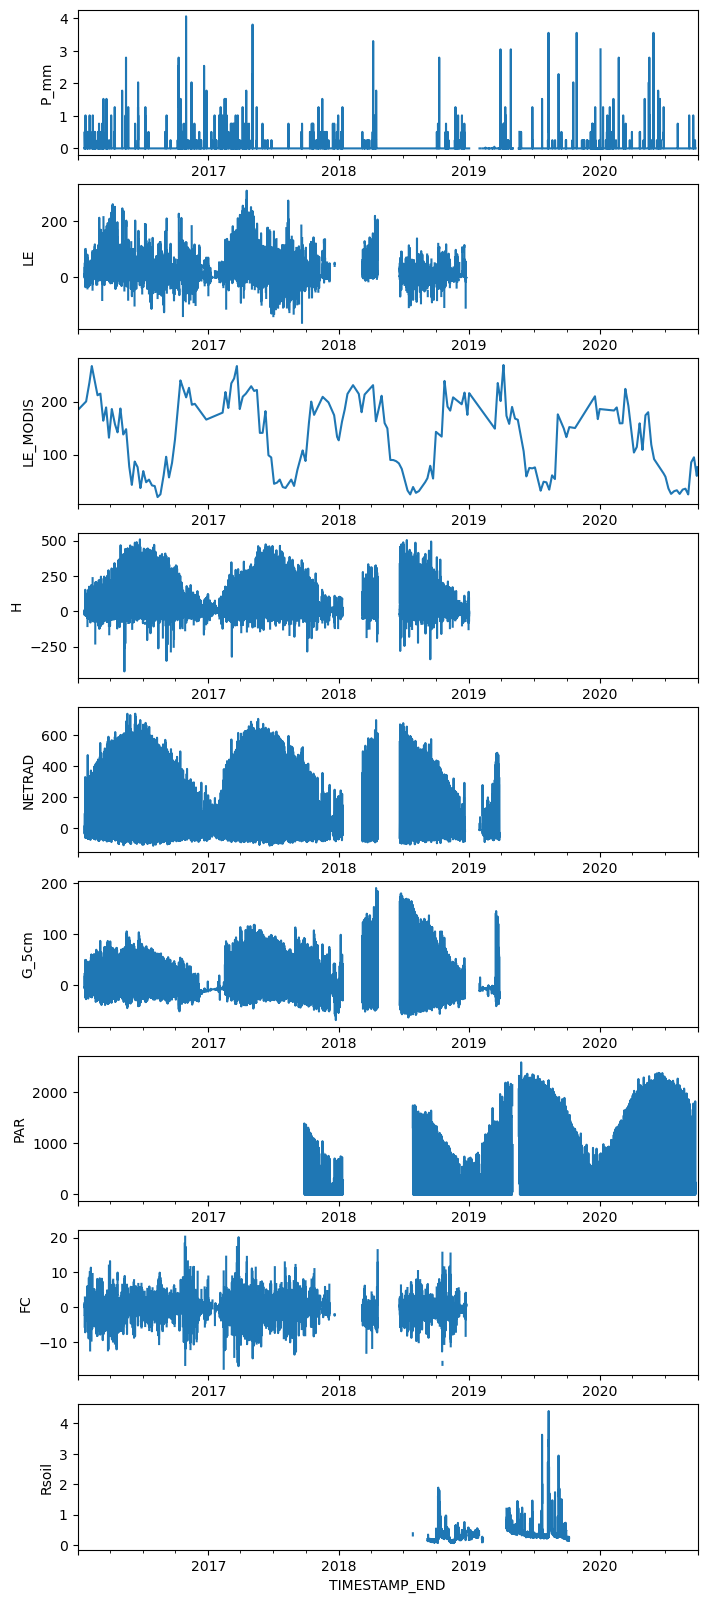

In [24]:
# The data to compare
out_varns = ["P_mm", "LE", "LE_MODIS", "H", "NETRAD", "G_5cm", "PAR", "FC", "Rsoil"]
varns = out_varns
fig, axes = plt.subplots(len(varns), 1, figsize=(8, 20))
for i, varn in enumerate(varns):
    ax = axes[i]
    df[varn].plot(ax=ax)
    ax.set(ylabel=varn)

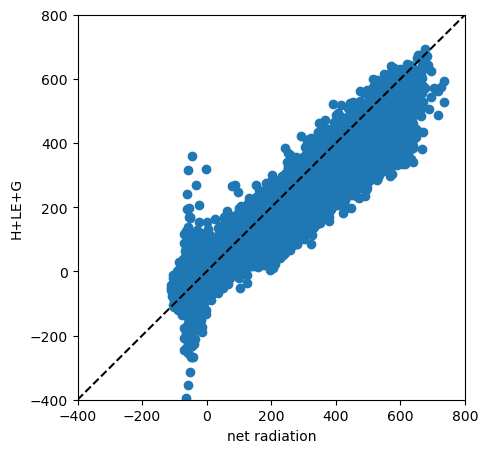

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
lim = [-400, 800]
ax.scatter(df["NETRAD"], df["H"] + df["LE"] + df["G_5cm"])
ax.plot(lim, lim, "k--")
ax.set(xlim=lim, ylim=lim, xlabel="net radiation", ylabel="H+LE+G");

In [26]:
# Save the data to compare
df_save = df[out_varns][start:end]
df_save.interpolate(inplace=True)
# np.savetxt('US-Hn1-fluxes.csv', df_save.values, delimiter=',')
df_save.to_csv(dir_flux_data / "US-Hn1-fluxes.csv", sep=",")